In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import tensorflow as tf
import numpy as np
import math
import matplotlib
from Loss_metrics import AUC
#matplotlib.use("Agg")
import matplotlib.image as mpimg
import glob
from data_utils import load_data, augment_data,normalise_train,normalise_test,rgb2gray,rgb2lab,lab2rgb
import matplotlib.pyplot as plt
from tucha import complex_pokemon_model,baselinish,simpler_model,baselinish2,complex_pokemon_model2, complex_pokemon_model3


In [3]:
X_train, X_test, Y_train, Y_test, labels_train, labels_test = load_data()
Y_train = np.asarray(Y_train)
print (Y_train.shape)
print (Y_train.dtype)

0
Shape of X_train, X_test, Y_train, Y_test: 481 121
(481, 64, 64, 3)
uint8


In [4]:
def show_images(images,gray = False):

    
    if(gray):
        plt.imshow(images,cmap = plt.get_cmap('gray'))
    else :
        plt.imshow(images);

    plt.show()

(481, 64, 64, 3)
INFO:tensorflow:Restoring parameters from ../models/image_net_pok_model_trained/new_model
0.019457


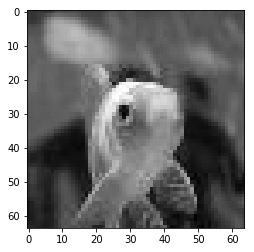

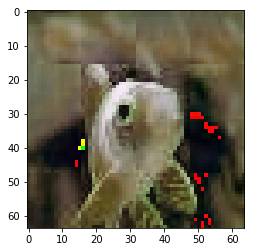

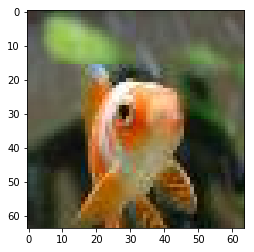

In [5]:
tf.reset_default_graph()

Y = tf.placeholder(tf.uint8 ,[None , 64,64,3])

is_training = tf.placeholder(tf.bool)

print (Y_train.shape)

with tf.variable_scope("model") as scope:
    #hsv_out,rgb_out,hsv_in,rgb_in = baselinish2(Y,is_training)
    hsv_out,rgb_out,hsv_in,rgb_in = complex_pokemon_model2(Y,is_training)
    loss = tf.reduce_mean(tf.square(rgb_out-rgb_in))
    
    global_step = tf.Variable(0, trainable=False)
    starter_learning_rate = 0.01
    learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step,
                                           100, 0.98, staircase=True)
# Passing global_step to minimize() will increment it at each step.
    train_step = (tf.train.AdamOptimizer(learning_rate).minimize(loss, global_step=global_step))
    #optimiser = tf.train.AdamOptimizer(1e-3)
    #train_step = optimiser.minimize(loss)


sess = tf.Session()
saver = tf.train.Saver()
saver.restore(sess,'../models/image_net_pok_model_trained/new_model')
import matplotlib.pyplot as plt
import numpy.random as rnd

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])


rand_indices = np.random.choice(100,48)
samp = Y_train[rand_indices]

feed_dict = {Y:samp,is_training:True}
losses,rgb_o,rgb_i = sess.run([loss,rgb_out,rgb_in],feed_dict)
print (losses)
show_images(rgb2gray(rgb_i[0]),gray = True)
show_images(rgb_o[0])
show_images(rgb_i[0])

    

589824
12288
0.958769155873


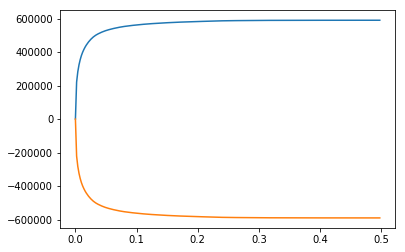

In [6]:
print(rgb_i.size)
print(rgb_o[0].size)
auc, ans = AUC(np.reshape(rgb_i, [48, 64, 64, 3]), np.reshape(rgb_o, [48, 64, 64, 3]))
print(ans)

plt.plot(np.arange(0., 0.5, 0.5/256), auc)
plt.plot(np.arange(0., 0.5, 0.5/256), 1-auc)

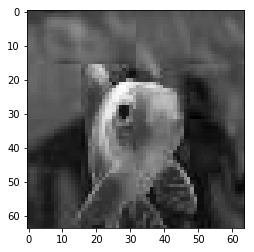

(196608, 3)


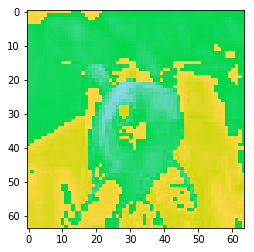

In [7]:
converter = np.array([[0.299,0.587,0.114],[-0.14713,-0.2888,0.436],
                                  [0.615,-0.514999,-0.10001]])
grayscale = np.reshape(rgb_i, [48*64*64, 3]).dot(converter)
grayscale[:,1:3] = -0.1
grayscale_vis = np.reshape(grayscale,[48,64,64,3])
show_images(grayscale_vis[0,:,:,0],gray = True)
inv_mat  = np.array([[1,0,1.13983],[1,-0.39465,-0.58060],[1,2.03211,0]])
rgb_gray = grayscale.dot(inv_mat)
print(rgb_gray.shape)
rgb_gray = np.reshape(rgb_gray, [48,64,64,3])
#print(np.reshape(rgb_gray, [48,64,64,3]).shape)
show_images(rgb_gray[0])

0.664967245526


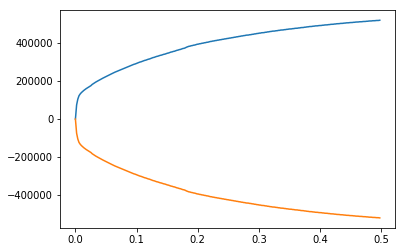

In [8]:
auc, ans = AUC(np.reshape(rgb_i, [48, 64, 64, 3]), np.reshape(rgb_gray, [48, 64, 64, 3]))
print(ans)

plt.plot(np.arange(0., 0.5, 0.5/256), auc)
plt.plot(np.arange(0., 0.5, 0.5/256), 1-auc)

24571.8


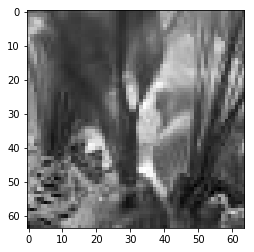

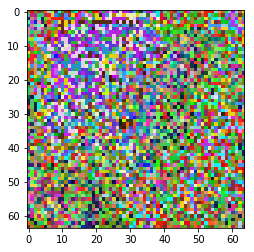

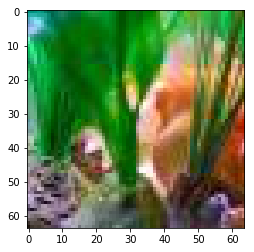

24571.8
24571.8
24571.8


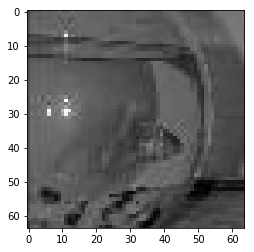

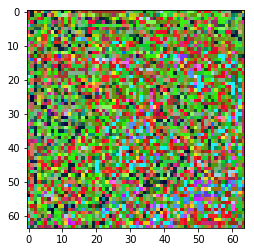

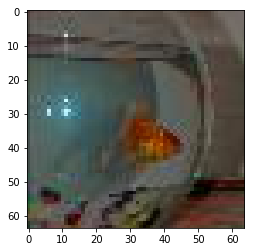

24571.8


In [ ]:
from Loss_metrics import Prob_dist
from skimage import img_as_float

tf.reset_default_graph()

X = tf.placeholder(tf.uint8 ,[None , 64,64,3])
Y = tf.placeholder(tf.float32,[None,64,64,400])

is_training = tf.placeholder(tf.bool)

#print (Y_train.shape)

with tf.variable_scope("model") as scope:
    UV_out,Y_in = complex_pokemon_model3(X,is_training)
    reshaped_Y = tf.reshape(Y,shape = [-1,400])
    reshaped_UV_out = tf.reshape(UV_out,shape = [-1,400])
    loss_temp = tf.nn.softmax_cross_entropy_with_logits(logits = reshaped_UV_out,labels = reshaped_Y )
    loss_reshaped = tf.reshape(loss_temp,[-1,64,64])
    loss = tf.reduce_sum(loss_reshaped,axis =[1,2])
    loss = tf.reduce_mean(loss)
    train_step = (tf.train.AdamOptimizer(1e-3).minimize(loss))

sess = tf.Session()
#saver = tf.train.Saver()
#saver.restore(sess,'../models/image_net_pok_model_trained/new_model')
import matplotlib.pyplot as plt
import numpy.random as rnd

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])


yuv_converter = np.array([[0.299,0.587,0.114],[-0.14713,-0.2888,0.436],
                                  [0.615,-0.514999,-0.10001]])
inv_mat  = np.array([[1,0,1.13983],[1,-0.39465,-0.58060],[1,2.03211,0]])

sess = tf.Session()
sess.run(tf.global_variables_initializer())
for i in range(10):
    rand_indices = np.random.choice(100,24,replace = False)
    samp = Y_train[rand_indices]
    
    samp_float = img_as_float(samp)
    samp_YUV = samp_float.dot(yuv_converter)
    prob_dist_batch = Prob_dist(samp_YUV)
    for j in range(10):
        feed_dict = {X:samp, Y:prob_dist_batch, is_training:True}
        losses,UV_o,y_in = sess.run([loss,UV_out,Y_in],feed_dict)
    
        UV_arg_max = np.argmax(UV_o,axis = 3)
        UV_arg_row_number = UV_arg_max/20
        UV_arg_column_number = UV_arg_max%20
        UV_bin = np.concatenate((UV_arg_row_number[...,np.newaxis],UV_arg_column_number[...,np.newaxis]),axis = 3)
        UV_val_a = -0.5 + UV_arg_row_number*0.05
        UV_val_b = -0.5 + UV_arg_column_number*0.05
        #print (y_in.shape)
        #print(UV_val_a.shape)
        #print (UV_val_b.shape)
        YUV_output = np.concatenate((y_in[...],UV_val_a[...,np.newaxis],UV_val_b[...,np.newaxis]),axis = 3)
        RGB_output = YUV_output.dot(inv_mat)
    ### SUper chutiyaapa 0.025
     
        print (losses)
        if(j%3==0):
            show_images(rgb2gray(samp[j]),gray = True)
            show_images(RGB_output[j])
            show_images(samp[j])